# Changelog
- Changed uncov to uconv, but removed the dropout in the last layer
- Corrected sanity check of predicted validation data (changed from ids_train to ids_valid)
- Used correct mask (from original train_df) for threshold tuning (inserted y_valid_ori)

# About
Since I am new to learning from image segmentation and kaggle in general I want to share my noteook.
I saw it is similar to others as it uses the U-net approach. I want to share it anyway because:

- As said, the field is new to me so I am open to suggestions.
- It visualizes some of the steps, e.g. scaling, to learn if the methods do what I expect which might be useful to others (I call them sanity checks).
- Added stratification by the amount of salt contained in the image.
- Added augmentation by flipping the images along the y axes (thanks to the forum for clarification).
- Added dropout to the model which seems to improve performance.

In [1]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

#If you have a 2nd GPU dedicated to ML uncomment the env lines to choose it
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="1" 

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook
import tensorflow as tf

Using TensorFlow backend.


In [2]:
#Either write script for these or do them manually one time per machine instance.
#import os
#!pip install kaggle
#make sure kaggle.json containing {"username":"*******","key":"******************************"} is in ~/.kaggle
#or in Windows in \Users\<username>\.kaggle folder
#!mkdir -p ../input
#!chdir ../input            or
#!cd ../input               or
# os.chdir("../input")
# !dir
#  using the kaggle.json credentials, download the kaggle data.  Must use
# !kaggle competitions download -c tgs-salt-identification-challenge
# !dir
# #unzip test.zip
# #unzip train.zip
# #!chdir ../Gap        or
# os.chdir("../Gap")
# !dir
# Check to see if tf sees your GPU.  if not pip install tensorflow-gpu

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())             

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4029325133766446868
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6669728481
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15346490809665577234
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


# Params and helpers

In [3]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [4]:
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [5]:
# !pip install ipywidgets
# !pip install jupyter


# !pip install widgetsnbextension

In [6]:
train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [8]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [9]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

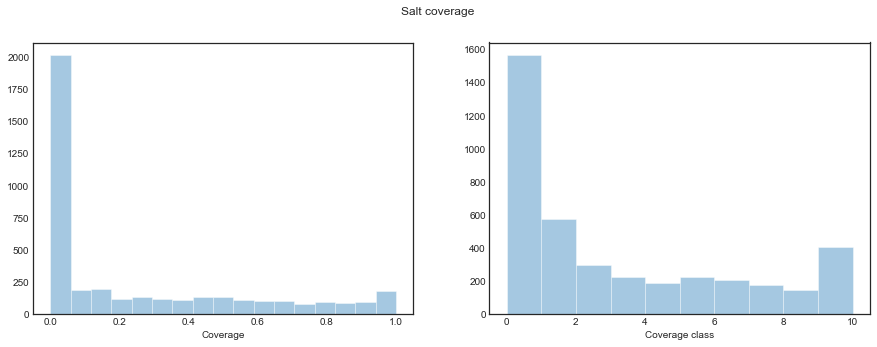

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

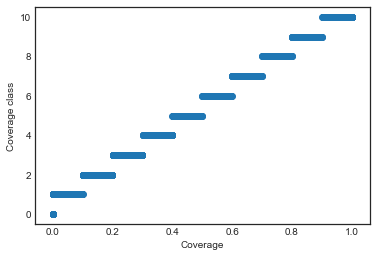

In [11]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

# Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data.

Text(0.5,1,'Depth distribution')

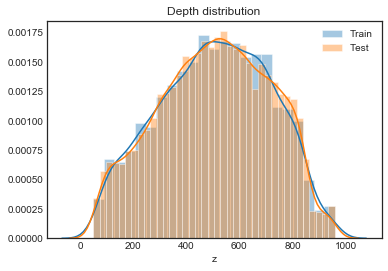

In [12]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Show some example images

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

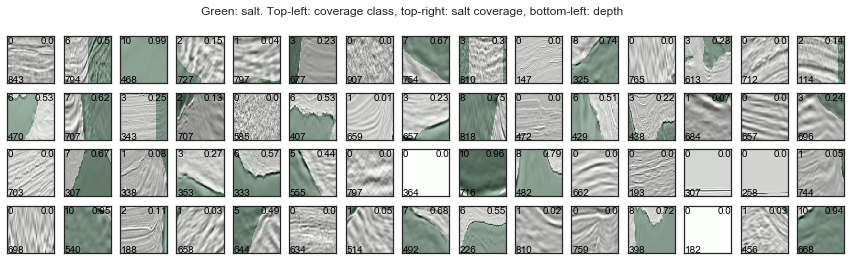

In [13]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [14]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Text(0.5,1,'Scaled image')

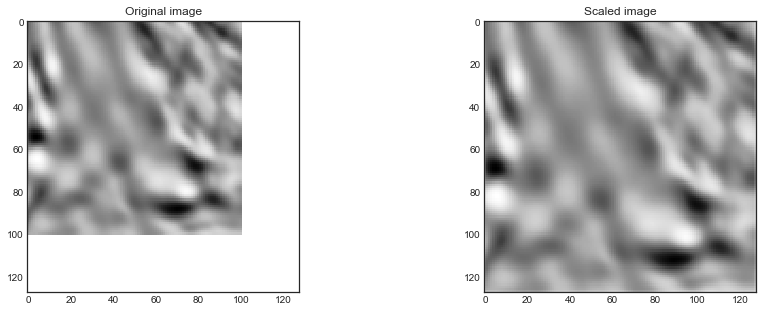

In [15]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

# Build model

In [16]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [17]:
model = Model(input_layer, output_layer)

In [18]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 1)  17          conv2d_18[0][0]                  
Total params: 2,158,417
Trainable params: 2,158,417
Non-trainable params: 0
__________________________________________________________________________________________________


# Data augmentation

In [20]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

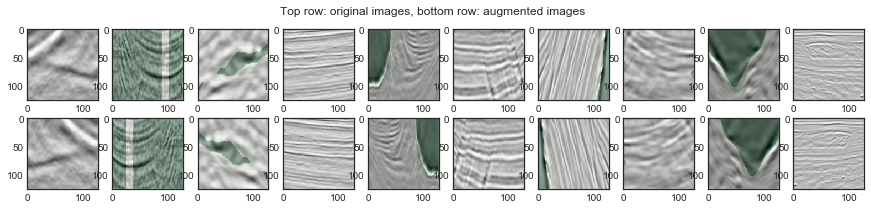

In [21]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Training

In [22]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - ETA: 10:54 - loss: 0.7372 - acc: 0.21 - ETA: 5:34 - loss: 0.7242 - acc: 0.2920 - ETA: 3:47 - loss: 0.7101 - acc: 0.408 - ETA: 2:54 - loss: 0.6969 - acc: 0.482 - ETA: 2:22 - loss: 0.6758 - acc: 0.537 - ETA: 2:00 - loss: 0.7984 - acc: 0.560 - ETA: 1:45 - loss: 0.7470 - acc: 0.606 - ETA: 1:33 - loss: 0.7283 - acc: 0.624 - ETA: 1:24 - loss: 0.7197 - acc: 0.629 - ETA: 1:17 - loss: 0.7134 - acc: 0.632 - ETA: 1:11 - loss: 0.7051 - acc: 0.644 - ETA: 1:06 - loss: 0.6987 - acc: 0.654 - ETA: 1:02 - loss: 0.6940 - acc: 0.659 - ETA: 58s - loss: 0.6873 - acc: 0.673 - ETA: 55s - loss: 0.6831 - acc: 0.67 - ETA: 52s - loss: 0.6817 - acc: 0.67 - ETA: 50s - loss: 0.6771 - acc: 0.68 - ETA: 48s - loss: 0.6721 - acc: 0.68 - ETA: 46s - loss: 0.6692 - acc: 0.69 - ETA: 44s - loss: 0.6641 - acc: 0.69 - ETA: 42s - loss: 0.6587 - acc: 0.70 - ETA: 41s - loss: 0.6554 - acc: 0.70 - ETA: 39s - loss: 0.6525 - acc: 0

6400/6400 [==============================] - ETA: 16s - loss: 0.4256 - acc: 0.74 - ETA: 16s - loss: 0.4303 - acc: 0.77 - ETA: 16s - loss: 0.4557 - acc: 0.74 - ETA: 16s - loss: 0.4717 - acc: 0.73 - ETA: 16s - loss: 0.4802 - acc: 0.71 - ETA: 16s - loss: 0.4898 - acc: 0.70 - ETA: 16s - loss: 0.4952 - acc: 0.71 - ETA: 16s - loss: 0.4872 - acc: 0.71 - ETA: 16s - loss: 0.4801 - acc: 0.72 - ETA: 16s - loss: 0.4994 - acc: 0.71 - ETA: 16s - loss: 0.4933 - acc: 0.71 - ETA: 16s - loss: 0.5000 - acc: 0.71 - ETA: 15s - loss: 0.5057 - acc: 0.71 - ETA: 15s - loss: 0.5127 - acc: 0.71 - ETA: 15s - loss: 0.5165 - acc: 0.71 - ETA: 15s - loss: 0.5170 - acc: 0.72 - ETA: 15s - loss: 0.5206 - acc: 0.71 - ETA: 15s - loss: 0.5163 - acc: 0.72 - ETA: 15s - loss: 0.5143 - acc: 0.72 - ETA: 15s - loss: 0.5021 - acc: 0.73 - ETA: 15s - loss: 0.5087 - acc: 0.72 - ETA: 15s - loss: 0.5049 - acc: 0.73 - ETA: 15s - loss: 0.5005 - acc: 0.73 - ETA: 15s - loss: 0.4991 - acc: 0.73 - ETA: 15s - loss: 0.4978 - acc: 0.73 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.4829 - acc: 0.76 - ETA: 16s - loss: 0.4149 - acc: 0.81 - ETA: 16s - loss: 0.3868 - acc: 0.82 - ETA: 16s - loss: 0.3885 - acc: 0.82 - ETA: 16s - loss: 0.3827 - acc: 0.82 - ETA: 16s - loss: 0.3918 - acc: 0.82 - ETA: 16s - loss: 0.3845 - acc: 0.82 - ETA: 16s - loss: 0.3835 - acc: 0.82 - ETA: 16s - loss: 0.3843 - acc: 0.82 - ETA: 16s - loss: 0.3937 - acc: 0.82 - ETA: 16s - loss: 0.3882 - acc: 0.82 - ETA: 16s - loss: 0.3988 - acc: 0.82 - ETA: 16s - loss: 0.3974 - acc: 0.82 - ETA: 16s - loss: 0.4008 - acc: 0.81 - ETA: 15s - loss: 0.3980 - acc: 0.82 - ETA: 15s - loss: 0.3975 - acc: 0.82 - ETA: 15s - loss: 0.3960 - acc: 0.82 - ETA: 15s - loss: 0.3912 - acc: 0.82 - ETA: 15s - loss: 0.3865 - acc: 0.82 - ETA: 15s - loss: 0.3822 - acc: 0.83 - ETA: 15s - loss: 0.3853 - acc: 0.82 - ETA: 15s - loss: 0.3850 - acc: 0.83 - ETA: 15s - loss: 0.3858 - acc: 0.83 - ETA: 15s - loss: 0.3848 - acc: 0.83 - ETA: 15s - loss: 0.3883 - acc: 0.82 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1987 - acc: 0.92 - ETA: 16s - loss: 0.3321 - acc: 0.86 - ETA: 16s - loss: 0.3920 - acc: 0.83 - ETA: 16s - loss: 0.3575 - acc: 0.85 - ETA: 16s - loss: 0.3645 - acc: 0.84 - ETA: 16s - loss: 0.3521 - acc: 0.85 - ETA: 16s - loss: 0.3466 - acc: 0.86 - ETA: 16s - loss: 0.3597 - acc: 0.85 - ETA: 16s - loss: 0.3482 - acc: 0.85 - ETA: 16s - loss: 0.3645 - acc: 0.84 - ETA: 16s - loss: 0.3843 - acc: 0.83 - ETA: 16s - loss: 0.3795 - acc: 0.83 - ETA: 16s - loss: 0.3782 - acc: 0.83 - ETA: 16s - loss: 0.3902 - acc: 0.83 - ETA: 15s - loss: 0.3958 - acc: 0.82 - ETA: 15s - loss: 0.4009 - acc: 0.82 - ETA: 15s - loss: 0.3953 - acc: 0.82 - ETA: 15s - loss: 0.3904 - acc: 0.83 - ETA: 15s - loss: 0.3911 - acc: 0.83 - ETA: 15s - loss: 0.3897 - acc: 0.83 - ETA: 15s - loss: 0.3885 - acc: 0.83 - ETA: 15s - loss: 0.3885 - acc: 0.83 - ETA: 15s - loss: 0.3845 - acc: 0.83 - ETA: 15s - loss: 0.3826 - acc: 0.83 - ETA: 15s - loss: 0.3775 - acc: 0.83 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2875 - acc: 0.87 - ETA: 16s - loss: 0.2662 - acc: 0.88 - ETA: 16s - loss: 0.3679 - acc: 0.84 - ETA: 16s - loss: 0.3542 - acc: 0.85 - ETA: 16s - loss: 0.3813 - acc: 0.84 - ETA: 16s - loss: 0.3538 - acc: 0.85 - ETA: 16s - loss: 0.3400 - acc: 0.86 - ETA: 16s - loss: 0.3205 - acc: 0.87 - ETA: 16s - loss: 0.3317 - acc: 0.86 - ETA: 16s - loss: 0.3437 - acc: 0.86 - ETA: 16s - loss: 0.3370 - acc: 0.86 - ETA: 16s - loss: 0.3336 - acc: 0.86 - ETA: 16s - loss: 0.3354 - acc: 0.86 - ETA: 16s - loss: 0.3277 - acc: 0.86 - ETA: 15s - loss: 0.3279 - acc: 0.86 - ETA: 15s - loss: 0.3319 - acc: 0.86 - ETA: 15s - loss: 0.3329 - acc: 0.86 - ETA: 15s - loss: 0.3255 - acc: 0.87 - ETA: 15s - loss: 0.3263 - acc: 0.86 - ETA: 15s - loss: 0.3226 - acc: 0.87 - ETA: 15s - loss: 0.3241 - acc: 0.87 - ETA: 15s - loss: 0.3219 - acc: 0.87 - ETA: 15s - loss: 0.3210 - acc: 0.87 - ETA: 15s - loss: 0.3229 - acc: 0.87 - ETA: 15s - loss: 0.3233 - acc: 0.86 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.4314 - acc: 0.81 - ETA: 17s - loss: 0.3987 - acc: 0.82 - ETA: 16s - loss: 0.3251 - acc: 0.86 - ETA: 16s - loss: 0.2907 - acc: 0.87 - ETA: 16s - loss: 0.2898 - acc: 0.87 - ETA: 16s - loss: 0.2802 - acc: 0.88 - ETA: 16s - loss: 0.2719 - acc: 0.89 - ETA: 16s - loss: 0.2731 - acc: 0.88 - ETA: 16s - loss: 0.2729 - acc: 0.89 - ETA: 16s - loss: 0.2648 - acc: 0.89 - ETA: 16s - loss: 0.2679 - acc: 0.89 - ETA: 16s - loss: 0.2721 - acc: 0.89 - ETA: 16s - loss: 0.2763 - acc: 0.88 - ETA: 15s - loss: 0.2846 - acc: 0.88 - ETA: 15s - loss: 0.2960 - acc: 0.87 - ETA: 15s - loss: 0.2934 - acc: 0.88 - ETA: 15s - loss: 0.2893 - acc: 0.88 - ETA: 15s - loss: 0.2854 - acc: 0.88 - ETA: 15s - loss: 0.2847 - acc: 0.88 - ETA: 15s - loss: 0.2872 - acc: 0.88 - ETA: 15s - loss: 0.2825 - acc: 0.88 - ETA: 15s - loss: 0.2887 - acc: 0.88 - ETA: 15s - loss: 0.2882 - acc: 0.88 - ETA: 15s - loss: 0.2853 - acc: 0.88 - ETA: 15s - loss: 0.2841 - acc: 0.88 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2522 - acc: 0.89 - ETA: 16s - loss: 0.2279 - acc: 0.91 - ETA: 16s - loss: 0.2945 - acc: 0.87 - ETA: 16s - loss: 0.2707 - acc: 0.89 - ETA: 16s - loss: 0.2837 - acc: 0.88 - ETA: 16s - loss: 0.2840 - acc: 0.88 - ETA: 16s - loss: 0.2849 - acc: 0.88 - ETA: 16s - loss: 0.2789 - acc: 0.88 - ETA: 16s - loss: 0.2852 - acc: 0.88 - ETA: 16s - loss: 0.2869 - acc: 0.88 - ETA: 16s - loss: 0.2853 - acc: 0.88 - ETA: 16s - loss: 0.2829 - acc: 0.88 - ETA: 16s - loss: 0.2814 - acc: 0.88 - ETA: 15s - loss: 0.2881 - acc: 0.88 - ETA: 15s - loss: 0.2850 - acc: 0.88 - ETA: 15s - loss: 0.2871 - acc: 0.88 - ETA: 15s - loss: 0.2953 - acc: 0.87 - ETA: 15s - loss: 0.3031 - acc: 0.87 - ETA: 15s - loss: 0.3027 - acc: 0.87 - ETA: 15s - loss: 0.3040 - acc: 0.87 - ETA: 15s - loss: 0.3068 - acc: 0.87 - ETA: 15s - loss: 0.3045 - acc: 0.87 - ETA: 15s - loss: 0.3035 - acc: 0.87 - ETA: 15s - loss: 0.3070 - acc: 0.87 - ETA: 15s - loss: 0.3096 - acc: 0.87 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2330 - acc: 0.90 - ETA: 16s - loss: 0.2194 - acc: 0.91 - ETA: 16s - loss: 0.2305 - acc: 0.90 - ETA: 16s - loss: 0.3011 - acc: 0.88 - ETA: 16s - loss: 0.3035 - acc: 0.88 - ETA: 16s - loss: 0.2826 - acc: 0.89 - ETA: 16s - loss: 0.2812 - acc: 0.89 - ETA: 16s - loss: 0.2802 - acc: 0.89 - ETA: 16s - loss: 0.2767 - acc: 0.89 - ETA: 16s - loss: 0.2775 - acc: 0.89 - ETA: 16s - loss: 0.2776 - acc: 0.89 - ETA: 16s - loss: 0.2739 - acc: 0.89 - ETA: 15s - loss: 0.2744 - acc: 0.89 - ETA: 15s - loss: 0.2712 - acc: 0.89 - ETA: 15s - loss: 0.2624 - acc: 0.89 - ETA: 15s - loss: 0.2685 - acc: 0.89 - ETA: 15s - loss: 0.2703 - acc: 0.89 - ETA: 15s - loss: 0.2668 - acc: 0.89 - ETA: 15s - loss: 0.2690 - acc: 0.89 - ETA: 15s - loss: 0.2694 - acc: 0.89 - ETA: 15s - loss: 0.2738 - acc: 0.88 - ETA: 15s - loss: 0.2758 - acc: 0.88 - ETA: 15s - loss: 0.2754 - acc: 0.88 - ETA: 15s - loss: 0.2725 - acc: 0.88 - ETA: 14s - loss: 0.2750 - acc: 0.88 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1925 - acc: 0.92 - ETA: 16s - loss: 0.2118 - acc: 0.91 - ETA: 16s - loss: 0.2260 - acc: 0.91 - ETA: 16s - loss: 0.2642 - acc: 0.90 - ETA: 16s - loss: 0.2452 - acc: 0.90 - ETA: 16s - loss: 0.2360 - acc: 0.90 - ETA: 16s - loss: 0.2250 - acc: 0.91 - ETA: 16s - loss: 0.2368 - acc: 0.90 - ETA: 16s - loss: 0.2512 - acc: 0.90 - ETA: 16s - loss: 0.2506 - acc: 0.90 - ETA: 16s - loss: 0.2482 - acc: 0.90 - ETA: 16s - loss: 0.2510 - acc: 0.90 - ETA: 16s - loss: 0.2572 - acc: 0.89 - ETA: 15s - loss: 0.2542 - acc: 0.89 - ETA: 15s - loss: 0.2639 - acc: 0.89 - ETA: 15s - loss: 0.2635 - acc: 0.89 - ETA: 15s - loss: 0.2609 - acc: 0.89 - ETA: 15s - loss: 0.2632 - acc: 0.89 - ETA: 15s - loss: 0.2622 - acc: 0.89 - ETA: 15s - loss: 0.2582 - acc: 0.89 - ETA: 15s - loss: 0.2595 - acc: 0.89 - ETA: 15s - loss: 0.2603 - acc: 0.89 - ETA: 15s - loss: 0.2604 - acc: 0.89 - ETA: 15s - loss: 0.2610 - acc: 0.89 - ETA: 15s - loss: 0.2567 - acc: 0.89 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2313 - acc: 0.90 - ETA: 16s - loss: 0.3213 - acc: 0.86 - ETA: 16s - loss: 0.2790 - acc: 0.88 - ETA: 16s - loss: 0.2966 - acc: 0.87 - ETA: 16s - loss: 0.2777 - acc: 0.88 - ETA: 16s - loss: 0.2618 - acc: 0.89 - ETA: 16s - loss: 0.2521 - acc: 0.89 - ETA: 16s - loss: 0.2681 - acc: 0.89 - ETA: 16s - loss: 0.2743 - acc: 0.88 - ETA: 16s - loss: 0.2724 - acc: 0.88 - ETA: 16s - loss: 0.2674 - acc: 0.88 - ETA: 16s - loss: 0.2650 - acc: 0.88 - ETA: 16s - loss: 0.2584 - acc: 0.89 - ETA: 16s - loss: 0.2536 - acc: 0.89 - ETA: 15s - loss: 0.2499 - acc: 0.89 - ETA: 15s - loss: 0.2480 - acc: 0.89 - ETA: 15s - loss: 0.2441 - acc: 0.89 - ETA: 15s - loss: 0.2460 - acc: 0.89 - ETA: 15s - loss: 0.2446 - acc: 0.89 - ETA: 15s - loss: 0.2457 - acc: 0.89 - ETA: 15s - loss: 0.2517 - acc: 0.89 - ETA: 15s - loss: 0.2587 - acc: 0.89 - ETA: 15s - loss: 0.2588 - acc: 0.89 - ETA: 15s - loss: 0.2563 - acc: 0.89 - ETA: 15s - loss: 0.2532 - acc: 0.89 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2204 - acc: 0.91 - ETA: 16s - loss: 0.2289 - acc: 0.91 - ETA: 16s - loss: 0.2278 - acc: 0.91 - ETA: 16s - loss: 0.2296 - acc: 0.90 - ETA: 16s - loss: 0.2419 - acc: 0.90 - ETA: 16s - loss: 0.2406 - acc: 0.90 - ETA: 16s - loss: 0.2563 - acc: 0.89 - ETA: 16s - loss: 0.2470 - acc: 0.89 - ETA: 16s - loss: 0.2607 - acc: 0.89 - ETA: 16s - loss: 0.2545 - acc: 0.89 - ETA: 16s - loss: 0.2595 - acc: 0.89 - ETA: 16s - loss: 0.2530 - acc: 0.89 - ETA: 16s - loss: 0.2452 - acc: 0.89 - ETA: 15s - loss: 0.2406 - acc: 0.90 - ETA: 15s - loss: 0.2436 - acc: 0.89 - ETA: 15s - loss: 0.2348 - acc: 0.90 - ETA: 15s - loss: 0.2371 - acc: 0.90 - ETA: 15s - loss: 0.2327 - acc: 0.90 - ETA: 15s - loss: 0.2372 - acc: 0.90 - ETA: 15s - loss: 0.2438 - acc: 0.89 - ETA: 15s - loss: 0.2405 - acc: 0.90 - ETA: 15s - loss: 0.2407 - acc: 0.90 - ETA: 15s - loss: 0.2479 - acc: 0.89 - ETA: 15s - loss: 0.2464 - acc: 0.89 - ETA: 15s - loss: 0.2459 - acc: 0.89 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2148 - acc: 0.90 - ETA: 16s - loss: 0.2065 - acc: 0.90 - ETA: 16s - loss: 0.1922 - acc: 0.91 - ETA: 16s - loss: 0.2118 - acc: 0.91 - ETA: 16s - loss: 0.1969 - acc: 0.91 - ETA: 16s - loss: 0.2045 - acc: 0.91 - ETA: 16s - loss: 0.1907 - acc: 0.92 - ETA: 16s - loss: 0.2196 - acc: 0.91 - ETA: 16s - loss: 0.2356 - acc: 0.91 - ETA: 16s - loss: 0.2288 - acc: 0.91 - ETA: 16s - loss: 0.2266 - acc: 0.91 - ETA: 16s - loss: 0.2245 - acc: 0.91 - ETA: 16s - loss: 0.2256 - acc: 0.91 - ETA: 16s - loss: 0.2278 - acc: 0.91 - ETA: 15s - loss: 0.2246 - acc: 0.91 - ETA: 15s - loss: 0.2201 - acc: 0.91 - ETA: 15s - loss: 0.2231 - acc: 0.91 - ETA: 15s - loss: 0.2254 - acc: 0.91 - ETA: 15s - loss: 0.2252 - acc: 0.91 - ETA: 15s - loss: 0.2249 - acc: 0.91 - ETA: 15s - loss: 0.2231 - acc: 0.91 - ETA: 15s - loss: 0.2263 - acc: 0.91 - ETA: 15s - loss: 0.2271 - acc: 0.91 - ETA: 15s - loss: 0.2325 - acc: 0.90 - ETA: 15s - loss: 0.2281 - acc: 0.90 - ETA: 

6400/6400 [==============================] - ETA: 17s - loss: 0.2054 - acc: 0.90 - ETA: 17s - loss: 0.2359 - acc: 0.88 - ETA: 16s - loss: 0.2416 - acc: 0.89 - ETA: 16s - loss: 0.2399 - acc: 0.89 - ETA: 16s - loss: 0.2594 - acc: 0.88 - ETA: 16s - loss: 0.2396 - acc: 0.89 - ETA: 16s - loss: 0.2261 - acc: 0.89 - ETA: 16s - loss: 0.2188 - acc: 0.90 - ETA: 16s - loss: 0.2133 - acc: 0.90 - ETA: 16s - loss: 0.2171 - acc: 0.90 - ETA: 16s - loss: 0.2262 - acc: 0.90 - ETA: 16s - loss: 0.2279 - acc: 0.90 - ETA: 15s - loss: 0.2258 - acc: 0.90 - ETA: 15s - loss: 0.2197 - acc: 0.90 - ETA: 15s - loss: 0.2180 - acc: 0.90 - ETA: 15s - loss: 0.2183 - acc: 0.90 - ETA: 15s - loss: 0.2188 - acc: 0.90 - ETA: 15s - loss: 0.2150 - acc: 0.90 - ETA: 15s - loss: 0.2198 - acc: 0.90 - ETA: 15s - loss: 0.2195 - acc: 0.90 - ETA: 15s - loss: 0.2243 - acc: 0.90 - ETA: 15s - loss: 0.2187 - acc: 0.90 - ETA: 15s - loss: 0.2170 - acc: 0.91 - ETA: 15s - loss: 0.2131 - acc: 0.91 - ETA: 15s - loss: 0.2108 - acc: 0.91 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2032 - acc: 0.92 - ETA: 16s - loss: 0.2186 - acc: 0.91 - ETA: 16s - loss: 0.2160 - acc: 0.91 - ETA: 16s - loss: 0.2092 - acc: 0.91 - ETA: 16s - loss: 0.2232 - acc: 0.91 - ETA: 16s - loss: 0.2101 - acc: 0.91 - ETA: 16s - loss: 0.2083 - acc: 0.91 - ETA: 16s - loss: 0.2073 - acc: 0.91 - ETA: 16s - loss: 0.2054 - acc: 0.91 - ETA: 16s - loss: 0.1936 - acc: 0.92 - ETA: 16s - loss: 0.2074 - acc: 0.91 - ETA: 16s - loss: 0.2084 - acc: 0.91 - ETA: 15s - loss: 0.2003 - acc: 0.91 - ETA: 15s - loss: 0.1960 - acc: 0.92 - ETA: 15s - loss: 0.1939 - acc: 0.92 - ETA: 15s - loss: 0.1900 - acc: 0.92 - ETA: 15s - loss: 0.1918 - acc: 0.92 - ETA: 15s - loss: 0.1947 - acc: 0.92 - ETA: 15s - loss: 0.1891 - acc: 0.92 - ETA: 15s - loss: 0.1859 - acc: 0.92 - ETA: 15s - loss: 0.1853 - acc: 0.92 - ETA: 15s - loss: 0.1894 - acc: 0.92 - ETA: 15s - loss: 0.1859 - acc: 0.92 - ETA: 15s - loss: 0.1846 - acc: 0.92 - ETA: 15s - loss: 0.1825 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2950 - acc: 0.87 - ETA: 16s - loss: 0.2889 - acc: 0.88 - ETA: 16s - loss: 0.2872 - acc: 0.88 - ETA: 16s - loss: 0.2539 - acc: 0.89 - ETA: 16s - loss: 0.2278 - acc: 0.91 - ETA: 16s - loss: 0.2156 - acc: 0.91 - ETA: 16s - loss: 0.2364 - acc: 0.90 - ETA: 16s - loss: 0.2327 - acc: 0.91 - ETA: 16s - loss: 0.2251 - acc: 0.91 - ETA: 16s - loss: 0.2213 - acc: 0.91 - ETA: 16s - loss: 0.2118 - acc: 0.91 - ETA: 16s - loss: 0.2133 - acc: 0.91 - ETA: 16s - loss: 0.2053 - acc: 0.91 - ETA: 15s - loss: 0.2014 - acc: 0.91 - ETA: 15s - loss: 0.2055 - acc: 0.91 - ETA: 15s - loss: 0.2090 - acc: 0.91 - ETA: 15s - loss: 0.2065 - acc: 0.91 - ETA: 15s - loss: 0.2147 - acc: 0.91 - ETA: 15s - loss: 0.2159 - acc: 0.90 - ETA: 15s - loss: 0.2168 - acc: 0.90 - ETA: 15s - loss: 0.2197 - acc: 0.90 - ETA: 15s - loss: 0.2170 - acc: 0.91 - ETA: 15s - loss: 0.2167 - acc: 0.91 - ETA: 15s - loss: 0.2150 - acc: 0.91 - ETA: 15s - loss: 0.2115 - acc: 0.91 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2725 - acc: 0.85 - ETA: 16s - loss: 0.2360 - acc: 0.88 - ETA: 16s - loss: 0.2411 - acc: 0.89 - ETA: 16s - loss: 0.2199 - acc: 0.90 - ETA: 16s - loss: 0.2189 - acc: 0.90 - ETA: 16s - loss: 0.2159 - acc: 0.90 - ETA: 16s - loss: 0.2148 - acc: 0.90 - ETA: 16s - loss: 0.2211 - acc: 0.90 - ETA: 16s - loss: 0.2108 - acc: 0.90 - ETA: 16s - loss: 0.2024 - acc: 0.91 - ETA: 16s - loss: 0.2008 - acc: 0.91 - ETA: 16s - loss: 0.1951 - acc: 0.91 - ETA: 16s - loss: 0.1954 - acc: 0.91 - ETA: 15s - loss: 0.1931 - acc: 0.91 - ETA: 15s - loss: 0.1895 - acc: 0.92 - ETA: 15s - loss: 0.1912 - acc: 0.91 - ETA: 15s - loss: 0.1889 - acc: 0.92 - ETA: 15s - loss: 0.1898 - acc: 0.92 - ETA: 15s - loss: 0.1900 - acc: 0.92 - ETA: 15s - loss: 0.1901 - acc: 0.92 - ETA: 15s - loss: 0.1934 - acc: 0.92 - ETA: 15s - loss: 0.1969 - acc: 0.91 - ETA: 15s - loss: 0.1954 - acc: 0.91 - ETA: 15s - loss: 0.1943 - acc: 0.91 - ETA: 15s - loss: 0.1926 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2317 - acc: 0.90 - ETA: 16s - loss: 0.2036 - acc: 0.92 - ETA: 16s - loss: 0.1852 - acc: 0.93 - ETA: 16s - loss: 0.1689 - acc: 0.93 - ETA: 16s - loss: 0.1723 - acc: 0.93 - ETA: 16s - loss: 0.1651 - acc: 0.93 - ETA: 16s - loss: 0.1721 - acc: 0.93 - ETA: 16s - loss: 0.1977 - acc: 0.92 - ETA: 16s - loss: 0.2053 - acc: 0.92 - ETA: 16s - loss: 0.2040 - acc: 0.92 - ETA: 16s - loss: 0.2029 - acc: 0.92 - ETA: 16s - loss: 0.2011 - acc: 0.92 - ETA: 16s - loss: 0.2027 - acc: 0.92 - ETA: 16s - loss: 0.1968 - acc: 0.92 - ETA: 15s - loss: 0.2020 - acc: 0.92 - ETA: 15s - loss: 0.2030 - acc: 0.92 - ETA: 15s - loss: 0.1984 - acc: 0.92 - ETA: 15s - loss: 0.2011 - acc: 0.92 - ETA: 15s - loss: 0.2024 - acc: 0.92 - ETA: 15s - loss: 0.2005 - acc: 0.92 - ETA: 15s - loss: 0.2005 - acc: 0.92 - ETA: 15s - loss: 0.2009 - acc: 0.92 - ETA: 15s - loss: 0.1983 - acc: 0.92 - ETA: 15s - loss: 0.1945 - acc: 0.92 - ETA: 15s - loss: 0.1951 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1864 - acc: 0.91 - ETA: 16s - loss: 0.1647 - acc: 0.93 - ETA: 16s - loss: 0.1683 - acc: 0.93 - ETA: 16s - loss: 0.1651 - acc: 0.93 - ETA: 16s - loss: 0.1752 - acc: 0.92 - ETA: 16s - loss: 0.1841 - acc: 0.92 - ETA: 16s - loss: 0.1799 - acc: 0.92 - ETA: 16s - loss: 0.1904 - acc: 0.91 - ETA: 16s - loss: 0.2012 - acc: 0.91 - ETA: 16s - loss: 0.2064 - acc: 0.90 - ETA: 16s - loss: 0.1954 - acc: 0.91 - ETA: 16s - loss: 0.1858 - acc: 0.91 - ETA: 16s - loss: 0.1811 - acc: 0.91 - ETA: 16s - loss: 0.1806 - acc: 0.91 - ETA: 15s - loss: 0.1811 - acc: 0.91 - ETA: 15s - loss: 0.1825 - acc: 0.91 - ETA: 15s - loss: 0.1848 - acc: 0.91 - ETA: 15s - loss: 0.1841 - acc: 0.91 - ETA: 15s - loss: 0.1888 - acc: 0.91 - ETA: 15s - loss: 0.1871 - acc: 0.91 - ETA: 15s - loss: 0.1869 - acc: 0.91 - ETA: 15s - loss: 0.1874 - acc: 0.91 - ETA: 15s - loss: 0.1864 - acc: 0.91 - ETA: 15s - loss: 0.1876 - acc: 0.91 - ETA: 15s - loss: 0.1878 - acc: 0.91 - ETA: 

6400/6400 [==============================] - ETA: 17s - loss: 0.1626 - acc: 0.92 - ETA: 16s - loss: 0.1439 - acc: 0.94 - ETA: 16s - loss: 0.1872 - acc: 0.92 - ETA: 16s - loss: 0.1815 - acc: 0.93 - ETA: 16s - loss: 0.1834 - acc: 0.93 - ETA: 16s - loss: 0.1947 - acc: 0.92 - ETA: 16s - loss: 0.2055 - acc: 0.92 - ETA: 16s - loss: 0.1963 - acc: 0.92 - ETA: 16s - loss: 0.1869 - acc: 0.92 - ETA: 16s - loss: 0.1791 - acc: 0.93 - ETA: 16s - loss: 0.1743 - acc: 0.93 - ETA: 16s - loss: 0.1713 - acc: 0.93 - ETA: 16s - loss: 0.1728 - acc: 0.93 - ETA: 15s - loss: 0.1708 - acc: 0.93 - ETA: 15s - loss: 0.1697 - acc: 0.93 - ETA: 15s - loss: 0.1753 - acc: 0.92 - ETA: 15s - loss: 0.1761 - acc: 0.92 - ETA: 15s - loss: 0.1768 - acc: 0.92 - ETA: 15s - loss: 0.1810 - acc: 0.92 - ETA: 15s - loss: 0.1788 - acc: 0.92 - ETA: 15s - loss: 0.1757 - acc: 0.92 - ETA: 15s - loss: 0.1780 - acc: 0.92 - ETA: 15s - loss: 0.1775 - acc: 0.92 - ETA: 15s - loss: 0.1771 - acc: 0.92 - ETA: 15s - loss: 0.1776 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0811 - acc: 0.96 - ETA: 16s - loss: 0.1180 - acc: 0.95 - ETA: 16s - loss: 0.1469 - acc: 0.94 - ETA: 16s - loss: 0.1417 - acc: 0.94 - ETA: 16s - loss: 0.1297 - acc: 0.94 - ETA: 16s - loss: 0.1382 - acc: 0.94 - ETA: 16s - loss: 0.1378 - acc: 0.94 - ETA: 16s - loss: 0.1456 - acc: 0.93 - ETA: 16s - loss: 0.1459 - acc: 0.93 - ETA: 16s - loss: 0.1471 - acc: 0.93 - ETA: 16s - loss: 0.1454 - acc: 0.93 - ETA: 16s - loss: 0.1434 - acc: 0.93 - ETA: 16s - loss: 0.1472 - acc: 0.93 - ETA: 16s - loss: 0.1452 - acc: 0.93 - ETA: 15s - loss: 0.1443 - acc: 0.93 - ETA: 15s - loss: 0.1446 - acc: 0.93 - ETA: 15s - loss: 0.1471 - acc: 0.93 - ETA: 15s - loss: 0.1452 - acc: 0.93 - ETA: 15s - loss: 0.1493 - acc: 0.93 - ETA: 15s - loss: 0.1555 - acc: 0.93 - ETA: 15s - loss: 0.1541 - acc: 0.93 - ETA: 15s - loss: 0.1554 - acc: 0.93 - ETA: 15s - loss: 0.1581 - acc: 0.92 - ETA: 15s - loss: 0.1552 - acc: 0.93 - ETA: 15s - loss: 0.1555 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1542 - acc: 0.93 - ETA: 16s - loss: 0.1810 - acc: 0.91 - ETA: 17s - loss: 0.1671 - acc: 0.92 - ETA: 16s - loss: 0.1708 - acc: 0.91 - ETA: 16s - loss: 0.1635 - acc: 0.92 - ETA: 16s - loss: 0.1660 - acc: 0.92 - ETA: 16s - loss: 0.1716 - acc: 0.91 - ETA: 16s - loss: 0.1686 - acc: 0.92 - ETA: 16s - loss: 0.1637 - acc: 0.92 - ETA: 16s - loss: 0.1632 - acc: 0.92 - ETA: 16s - loss: 0.1605 - acc: 0.92 - ETA: 16s - loss: 0.1639 - acc: 0.92 - ETA: 16s - loss: 0.1626 - acc: 0.92 - ETA: 16s - loss: 0.1732 - acc: 0.92 - ETA: 15s - loss: 0.1773 - acc: 0.92 - ETA: 15s - loss: 0.1725 - acc: 0.92 - ETA: 15s - loss: 0.1753 - acc: 0.92 - ETA: 15s - loss: 0.1799 - acc: 0.92 - ETA: 15s - loss: 0.1797 - acc: 0.92 - ETA: 15s - loss: 0.1768 - acc: 0.92 - ETA: 15s - loss: 0.1770 - acc: 0.92 - ETA: 15s - loss: 0.1766 - acc: 0.92 - ETA: 15s - loss: 0.1753 - acc: 0.92 - ETA: 15s - loss: 0.1745 - acc: 0.92 - ETA: 15s - loss: 0.1730 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1832 - acc: 0.92 - ETA: 16s - loss: 0.1537 - acc: 0.93 - ETA: 17s - loss: 0.1319 - acc: 0.93 - ETA: 17s - loss: 0.1394 - acc: 0.93 - ETA: 16s - loss: 0.1422 - acc: 0.93 - ETA: 16s - loss: 0.1428 - acc: 0.93 - ETA: 16s - loss: 0.1339 - acc: 0.94 - ETA: 16s - loss: 0.1393 - acc: 0.93 - ETA: 16s - loss: 0.1495 - acc: 0.93 - ETA: 16s - loss: 0.1590 - acc: 0.92 - ETA: 16s - loss: 0.1520 - acc: 0.93 - ETA: 16s - loss: 0.1459 - acc: 0.93 - ETA: 16s - loss: 0.1534 - acc: 0.93 - ETA: 16s - loss: 0.1520 - acc: 0.93 - ETA: 16s - loss: 0.1514 - acc: 0.93 - ETA: 15s - loss: 0.1497 - acc: 0.93 - ETA: 15s - loss: 0.1573 - acc: 0.93 - ETA: 15s - loss: 0.1598 - acc: 0.93 - ETA: 15s - loss: 0.1594 - acc: 0.93 - ETA: 15s - loss: 0.1603 - acc: 0.92 - ETA: 15s - loss: 0.1588 - acc: 0.92 - ETA: 15s - loss: 0.1592 - acc: 0.92 - ETA: 15s - loss: 0.1584 - acc: 0.92 - ETA: 15s - loss: 0.1585 - acc: 0.92 - ETA: 15s - loss: 0.1567 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1555 - acc: 0.94 - ETA: 16s - loss: 0.1721 - acc: 0.92 - ETA: 16s - loss: 0.1570 - acc: 0.93 - ETA: 16s - loss: 0.1852 - acc: 0.92 - ETA: 16s - loss: 0.1722 - acc: 0.92 - ETA: 16s - loss: 0.1663 - acc: 0.92 - ETA: 16s - loss: 0.1597 - acc: 0.93 - ETA: 16s - loss: 0.1687 - acc: 0.92 - ETA: 16s - loss: 0.1947 - acc: 0.91 - ETA: 16s - loss: 0.1969 - acc: 0.91 - ETA: 16s - loss: 0.1871 - acc: 0.91 - ETA: 16s - loss: 0.1841 - acc: 0.91 - ETA: 16s - loss: 0.1835 - acc: 0.91 - ETA: 16s - loss: 0.1803 - acc: 0.92 - ETA: 16s - loss: 0.1769 - acc: 0.92 - ETA: 15s - loss: 0.1791 - acc: 0.92 - ETA: 15s - loss: 0.1748 - acc: 0.92 - ETA: 15s - loss: 0.1719 - acc: 0.92 - ETA: 15s - loss: 0.1690 - acc: 0.92 - ETA: 15s - loss: 0.1717 - acc: 0.92 - ETA: 15s - loss: 0.1725 - acc: 0.92 - ETA: 15s - loss: 0.1709 - acc: 0.92 - ETA: 15s - loss: 0.1699 - acc: 0.92 - ETA: 15s - loss: 0.1773 - acc: 0.92 - ETA: 15s - loss: 0.1740 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1468 - acc: 0.94 - ETA: 16s - loss: 0.1346 - acc: 0.94 - ETA: 16s - loss: 0.1399 - acc: 0.93 - ETA: 16s - loss: 0.1529 - acc: 0.93 - ETA: 16s - loss: 0.1627 - acc: 0.92 - ETA: 16s - loss: 0.1616 - acc: 0.92 - ETA: 16s - loss: 0.1603 - acc: 0.92 - ETA: 16s - loss: 0.1575 - acc: 0.93 - ETA: 16s - loss: 0.1601 - acc: 0.92 - ETA: 16s - loss: 0.1606 - acc: 0.92 - ETA: 16s - loss: 0.1637 - acc: 0.92 - ETA: 16s - loss: 0.1589 - acc: 0.92 - ETA: 16s - loss: 0.1615 - acc: 0.92 - ETA: 16s - loss: 0.1639 - acc: 0.92 - ETA: 16s - loss: 0.1652 - acc: 0.92 - ETA: 15s - loss: 0.1658 - acc: 0.92 - ETA: 15s - loss: 0.1657 - acc: 0.92 - ETA: 15s - loss: 0.1635 - acc: 0.92 - ETA: 15s - loss: 0.1601 - acc: 0.92 - ETA: 15s - loss: 0.1586 - acc: 0.93 - ETA: 15s - loss: 0.1594 - acc: 0.92 - ETA: 15s - loss: 0.1573 - acc: 0.93 - ETA: 15s - loss: 0.1553 - acc: 0.93 - ETA: 15s - loss: 0.1558 - acc: 0.93 - ETA: 15s - loss: 0.1559 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1875 - acc: 0.91 - ETA: 16s - loss: 0.1711 - acc: 0.92 - ETA: 16s - loss: 0.1489 - acc: 0.93 - ETA: 16s - loss: 0.1456 - acc: 0.93 - ETA: 16s - loss: 0.1423 - acc: 0.94 - ETA: 16s - loss: 0.1388 - acc: 0.93 - ETA: 16s - loss: 0.1331 - acc: 0.94 - ETA: 16s - loss: 0.1321 - acc: 0.94 - ETA: 16s - loss: 0.1283 - acc: 0.94 - ETA: 16s - loss: 0.1289 - acc: 0.94 - ETA: 16s - loss: 0.1294 - acc: 0.94 - ETA: 16s - loss: 0.1252 - acc: 0.94 - ETA: 16s - loss: 0.1377 - acc: 0.94 - ETA: 15s - loss: 0.1371 - acc: 0.94 - ETA: 15s - loss: 0.1370 - acc: 0.94 - ETA: 15s - loss: 0.1338 - acc: 0.94 - ETA: 15s - loss: 0.1327 - acc: 0.94 - ETA: 15s - loss: 0.1333 - acc: 0.94 - ETA: 15s - loss: 0.1391 - acc: 0.93 - ETA: 15s - loss: 0.1415 - acc: 0.93 - ETA: 15s - loss: 0.1425 - acc: 0.93 - ETA: 15s - loss: 0.1441 - acc: 0.93 - ETA: 15s - loss: 0.1410 - acc: 0.93 - ETA: 15s - loss: 0.1425 - acc: 0.93 - ETA: 15s - loss: 0.1461 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 17s - loss: 0.1318 - acc: 0.93 - ETA: 16s - loss: 0.1218 - acc: 0.94 - ETA: 16s - loss: 0.1592 - acc: 0.93 - ETA: 16s - loss: 0.1492 - acc: 0.93 - ETA: 16s - loss: 0.1415 - acc: 0.93 - ETA: 16s - loss: 0.1408 - acc: 0.93 - ETA: 16s - loss: 0.1451 - acc: 0.93 - ETA: 16s - loss: 0.1648 - acc: 0.92 - ETA: 16s - loss: 0.1666 - acc: 0.92 - ETA: 16s - loss: 0.1608 - acc: 0.92 - ETA: 16s - loss: 0.1623 - acc: 0.92 - ETA: 16s - loss: 0.1635 - acc: 0.92 - ETA: 16s - loss: 0.1648 - acc: 0.92 - ETA: 16s - loss: 0.1598 - acc: 0.92 - ETA: 15s - loss: 0.1561 - acc: 0.93 - ETA: 15s - loss: 0.1509 - acc: 0.93 - ETA: 15s - loss: 0.1541 - acc: 0.93 - ETA: 15s - loss: 0.1526 - acc: 0.93 - ETA: 15s - loss: 0.1523 - acc: 0.93 - ETA: 15s - loss: 0.1531 - acc: 0.93 - ETA: 15s - loss: 0.1548 - acc: 0.92 - ETA: 15s - loss: 0.1544 - acc: 0.92 - ETA: 15s - loss: 0.1536 - acc: 0.92 - ETA: 15s - loss: 0.1572 - acc: 0.92 - ETA: 15s - loss: 0.1532 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0859 - acc: 0.96 - ETA: 16s - loss: 0.0944 - acc: 0.95 - ETA: 16s - loss: 0.1081 - acc: 0.95 - ETA: 16s - loss: 0.1278 - acc: 0.94 - ETA: 16s - loss: 0.1415 - acc: 0.93 - ETA: 16s - loss: 0.1428 - acc: 0.93 - ETA: 16s - loss: 0.1378 - acc: 0.93 - ETA: 16s - loss: 0.1418 - acc: 0.93 - ETA: 16s - loss: 0.1413 - acc: 0.93 - ETA: 16s - loss: 0.1451 - acc: 0.93 - ETA: 16s - loss: 0.1488 - acc: 0.93 - ETA: 16s - loss: 0.1497 - acc: 0.93 - ETA: 16s - loss: 0.1466 - acc: 0.93 - ETA: 16s - loss: 0.1490 - acc: 0.93 - ETA: 16s - loss: 0.1518 - acc: 0.93 - ETA: 15s - loss: 0.1469 - acc: 0.93 - ETA: 15s - loss: 0.1484 - acc: 0.93 - ETA: 15s - loss: 0.1509 - acc: 0.93 - ETA: 15s - loss: 0.1494 - acc: 0.93 - ETA: 15s - loss: 0.1487 - acc: 0.93 - ETA: 15s - loss: 0.1502 - acc: 0.93 - ETA: 15s - loss: 0.1492 - acc: 0.93 - ETA: 15s - loss: 0.1487 - acc: 0.93 - ETA: 15s - loss: 0.1479 - acc: 0.93 - ETA: 15s - loss: 0.1477 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2334 - acc: 0.91 - ETA: 16s - loss: 0.2966 - acc: 0.87 - ETA: 16s - loss: 0.2494 - acc: 0.88 - ETA: 16s - loss: 0.2469 - acc: 0.88 - ETA: 16s - loss: 0.2510 - acc: 0.88 - ETA: 16s - loss: 0.2393 - acc: 0.88 - ETA: 16s - loss: 0.2375 - acc: 0.89 - ETA: 16s - loss: 0.2258 - acc: 0.89 - ETA: 16s - loss: 0.2243 - acc: 0.89 - ETA: 16s - loss: 0.2227 - acc: 0.89 - ETA: 16s - loss: 0.2133 - acc: 0.90 - ETA: 16s - loss: 0.2082 - acc: 0.90 - ETA: 16s - loss: 0.2061 - acc: 0.90 - ETA: 16s - loss: 0.1978 - acc: 0.91 - ETA: 15s - loss: 0.1910 - acc: 0.91 - ETA: 15s - loss: 0.1955 - acc: 0.91 - ETA: 15s - loss: 0.1929 - acc: 0.91 - ETA: 15s - loss: 0.1985 - acc: 0.91 - ETA: 15s - loss: 0.1991 - acc: 0.91 - ETA: 15s - loss: 0.1920 - acc: 0.91 - ETA: 15s - loss: 0.1885 - acc: 0.91 - ETA: 15s - loss: 0.1856 - acc: 0.91 - ETA: 15s - loss: 0.1871 - acc: 0.91 - ETA: 15s - loss: 0.1830 - acc: 0.92 - ETA: 15s - loss: 0.1829 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.2148 - acc: 0.90 - ETA: 16s - loss: 0.1838 - acc: 0.92 - ETA: 16s - loss: 0.1608 - acc: 0.93 - ETA: 16s - loss: 0.1552 - acc: 0.93 - ETA: 16s - loss: 0.1690 - acc: 0.92 - ETA: 16s - loss: 0.1726 - acc: 0.92 - ETA: 16s - loss: 0.1639 - acc: 0.93 - ETA: 16s - loss: 0.1644 - acc: 0.93 - ETA: 16s - loss: 0.1654 - acc: 0.92 - ETA: 16s - loss: 0.1601 - acc: 0.92 - ETA: 16s - loss: 0.1561 - acc: 0.93 - ETA: 16s - loss: 0.1582 - acc: 0.93 - ETA: 16s - loss: 0.1567 - acc: 0.93 - ETA: 16s - loss: 0.1548 - acc: 0.93 - ETA: 15s - loss: 0.1560 - acc: 0.93 - ETA: 15s - loss: 0.1554 - acc: 0.93 - ETA: 15s - loss: 0.1534 - acc: 0.93 - ETA: 15s - loss: 0.1494 - acc: 0.93 - ETA: 15s - loss: 0.1487 - acc: 0.93 - ETA: 15s - loss: 0.1458 - acc: 0.93 - ETA: 15s - loss: 0.1426 - acc: 0.93 - ETA: 15s - loss: 0.1457 - acc: 0.93 - ETA: 15s - loss: 0.1481 - acc: 0.93 - ETA: 15s - loss: 0.1468 - acc: 0.93 - ETA: 15s - loss: 0.1442 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1027 - acc: 0.94 - ETA: 16s - loss: 0.1689 - acc: 0.91 - ETA: 16s - loss: 0.1569 - acc: 0.92 - ETA: 16s - loss: 0.1415 - acc: 0.93 - ETA: 16s - loss: 0.1321 - acc: 0.93 - ETA: 16s - loss: 0.1369 - acc: 0.93 - ETA: 16s - loss: 0.1359 - acc: 0.93 - ETA: 16s - loss: 0.1306 - acc: 0.94 - ETA: 16s - loss: 0.1311 - acc: 0.94 - ETA: 16s - loss: 0.1370 - acc: 0.93 - ETA: 16s - loss: 0.1405 - acc: 0.93 - ETA: 16s - loss: 0.1460 - acc: 0.93 - ETA: 16s - loss: 0.1405 - acc: 0.93 - ETA: 16s - loss: 0.1516 - acc: 0.93 - ETA: 15s - loss: 0.1482 - acc: 0.93 - ETA: 15s - loss: 0.1474 - acc: 0.93 - ETA: 15s - loss: 0.1465 - acc: 0.93 - ETA: 15s - loss: 0.1487 - acc: 0.93 - ETA: 15s - loss: 0.1470 - acc: 0.93 - ETA: 15s - loss: 0.1480 - acc: 0.93 - ETA: 15s - loss: 0.1499 - acc: 0.93 - ETA: 15s - loss: 0.1519 - acc: 0.93 - ETA: 15s - loss: 0.1525 - acc: 0.93 - ETA: 15s - loss: 0.1517 - acc: 0.93 - ETA: 15s - loss: 0.1500 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1744 - acc: 0.92 - ETA: 16s - loss: 0.1422 - acc: 0.93 - ETA: 16s - loss: 0.1437 - acc: 0.93 - ETA: 16s - loss: 0.1645 - acc: 0.92 - ETA: 16s - loss: 0.1584 - acc: 0.92 - ETA: 16s - loss: 0.1557 - acc: 0.92 - ETA: 16s - loss: 0.1467 - acc: 0.93 - ETA: 16s - loss: 0.1425 - acc: 0.93 - ETA: 16s - loss: 0.1459 - acc: 0.93 - ETA: 16s - loss: 0.1502 - acc: 0.93 - ETA: 16s - loss: 0.1578 - acc: 0.92 - ETA: 16s - loss: 0.1593 - acc: 0.92 - ETA: 16s - loss: 0.1559 - acc: 0.92 - ETA: 16s - loss: 0.1515 - acc: 0.93 - ETA: 15s - loss: 0.1482 - acc: 0.93 - ETA: 15s - loss: 0.1513 - acc: 0.93 - ETA: 15s - loss: 0.1528 - acc: 0.93 - ETA: 15s - loss: 0.1549 - acc: 0.92 - ETA: 15s - loss: 0.1536 - acc: 0.92 - ETA: 15s - loss: 0.1573 - acc: 0.92 - ETA: 15s - loss: 0.1601 - acc: 0.92 - ETA: 15s - loss: 0.1576 - acc: 0.92 - ETA: 15s - loss: 0.1598 - acc: 0.92 - ETA: 15s - loss: 0.1583 - acc: 0.92 - ETA: 15s - loss: 0.1572 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0799 - acc: 0.96 - ETA: 17s - loss: 0.0976 - acc: 0.95 - ETA: 16s - loss: 0.1201 - acc: 0.94 - ETA: 16s - loss: 0.1565 - acc: 0.92 - ETA: 16s - loss: 0.1487 - acc: 0.92 - ETA: 16s - loss: 0.1428 - acc: 0.93 - ETA: 16s - loss: 0.1441 - acc: 0.93 - ETA: 16s - loss: 0.1476 - acc: 0.93 - ETA: 16s - loss: 0.1483 - acc: 0.93 - ETA: 16s - loss: 0.1448 - acc: 0.93 - ETA: 16s - loss: 0.1467 - acc: 0.93 - ETA: 16s - loss: 0.1485 - acc: 0.93 - ETA: 16s - loss: 0.1453 - acc: 0.93 - ETA: 16s - loss: 0.1493 - acc: 0.93 - ETA: 15s - loss: 0.1455 - acc: 0.93 - ETA: 15s - loss: 0.1460 - acc: 0.93 - ETA: 15s - loss: 0.1470 - acc: 0.93 - ETA: 15s - loss: 0.1457 - acc: 0.93 - ETA: 15s - loss: 0.1423 - acc: 0.93 - ETA: 15s - loss: 0.1457 - acc: 0.93 - ETA: 15s - loss: 0.1471 - acc: 0.93 - ETA: 15s - loss: 0.1465 - acc: 0.93 - ETA: 15s - loss: 0.1444 - acc: 0.93 - ETA: 15s - loss: 0.1427 - acc: 0.93 - ETA: 15s - loss: 0.1438 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1715 - acc: 0.93 - ETA: 16s - loss: 0.1845 - acc: 0.92 - ETA: 16s - loss: 0.1629 - acc: 0.93 - ETA: 16s - loss: 0.1635 - acc: 0.92 - ETA: 16s - loss: 0.1691 - acc: 0.91 - ETA: 16s - loss: 0.1554 - acc: 0.92 - ETA: 16s - loss: 0.1540 - acc: 0.92 - ETA: 16s - loss: 0.1487 - acc: 0.93 - ETA: 16s - loss: 0.1510 - acc: 0.93 - ETA: 16s - loss: 0.1467 - acc: 0.93 - ETA: 16s - loss: 0.1455 - acc: 0.93 - ETA: 16s - loss: 0.1461 - acc: 0.93 - ETA: 16s - loss: 0.1488 - acc: 0.93 - ETA: 16s - loss: 0.1451 - acc: 0.93 - ETA: 16s - loss: 0.1428 - acc: 0.93 - ETA: 15s - loss: 0.1430 - acc: 0.93 - ETA: 15s - loss: 0.1402 - acc: 0.93 - ETA: 15s - loss: 0.1403 - acc: 0.93 - ETA: 15s - loss: 0.1452 - acc: 0.93 - ETA: 15s - loss: 0.1446 - acc: 0.93 - ETA: 15s - loss: 0.1439 - acc: 0.93 - ETA: 15s - loss: 0.1423 - acc: 0.93 - ETA: 15s - loss: 0.1405 - acc: 0.93 - ETA: 15s - loss: 0.1474 - acc: 0.93 - ETA: 15s - loss: 0.1508 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 17s - loss: 0.2104 - acc: 0.89 - ETA: 16s - loss: 0.1651 - acc: 0.92 - ETA: 16s - loss: 0.1726 - acc: 0.91 - ETA: 16s - loss: 0.1472 - acc: 0.93 - ETA: 16s - loss: 0.1380 - acc: 0.93 - ETA: 16s - loss: 0.1396 - acc: 0.93 - ETA: 16s - loss: 0.1435 - acc: 0.93 - ETA: 16s - loss: 0.1419 - acc: 0.93 - ETA: 16s - loss: 0.1357 - acc: 0.93 - ETA: 16s - loss: 0.1310 - acc: 0.93 - ETA: 16s - loss: 0.1307 - acc: 0.94 - ETA: 16s - loss: 0.1301 - acc: 0.94 - ETA: 16s - loss: 0.1285 - acc: 0.94 - ETA: 16s - loss: 0.1312 - acc: 0.94 - ETA: 15s - loss: 0.1264 - acc: 0.94 - ETA: 15s - loss: 0.1238 - acc: 0.94 - ETA: 15s - loss: 0.1210 - acc: 0.94 - ETA: 15s - loss: 0.1188 - acc: 0.94 - ETA: 15s - loss: 0.1219 - acc: 0.94 - ETA: 15s - loss: 0.1229 - acc: 0.94 - ETA: 15s - loss: 0.1270 - acc: 0.94 - ETA: 15s - loss: 0.1271 - acc: 0.94 - ETA: 15s - loss: 0.1316 - acc: 0.94 - ETA: 15s - loss: 0.1333 - acc: 0.93 - ETA: 15s - loss: 0.1320 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1849 - acc: 0.91 - ETA: 16s - loss: 0.1462 - acc: 0.93 - ETA: 16s - loss: 0.1523 - acc: 0.93 - ETA: 16s - loss: 0.1347 - acc: 0.94 - ETA: 16s - loss: 0.1409 - acc: 0.93 - ETA: 16s - loss: 0.1580 - acc: 0.93 - ETA: 16s - loss: 0.1554 - acc: 0.93 - ETA: 16s - loss: 0.1452 - acc: 0.93 - ETA: 16s - loss: 0.1502 - acc: 0.93 - ETA: 16s - loss: 0.1483 - acc: 0.93 - ETA: 16s - loss: 0.1430 - acc: 0.93 - ETA: 16s - loss: 0.1433 - acc: 0.93 - ETA: 16s - loss: 0.1445 - acc: 0.93 - ETA: 16s - loss: 0.1460 - acc: 0.93 - ETA: 15s - loss: 0.1451 - acc: 0.93 - ETA: 15s - loss: 0.1430 - acc: 0.93 - ETA: 15s - loss: 0.1481 - acc: 0.93 - ETA: 15s - loss: 0.1467 - acc: 0.93 - ETA: 15s - loss: 0.1468 - acc: 0.93 - ETA: 15s - loss: 0.1436 - acc: 0.93 - ETA: 15s - loss: 0.1451 - acc: 0.93 - ETA: 15s - loss: 0.1477 - acc: 0.93 - ETA: 15s - loss: 0.1459 - acc: 0.93 - ETA: 15s - loss: 0.1470 - acc: 0.93 - ETA: 15s - loss: 0.1472 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1191 - acc: 0.94 - ETA: 16s - loss: 0.1079 - acc: 0.95 - ETA: 16s - loss: 0.1249 - acc: 0.94 - ETA: 16s - loss: 0.1226 - acc: 0.93 - ETA: 16s - loss: 0.1425 - acc: 0.93 - ETA: 16s - loss: 0.1281 - acc: 0.93 - ETA: 16s - loss: 0.1235 - acc: 0.94 - ETA: 16s - loss: 0.1314 - acc: 0.93 - ETA: 16s - loss: 0.1392 - acc: 0.93 - ETA: 16s - loss: 0.1401 - acc: 0.93 - ETA: 16s - loss: 0.1392 - acc: 0.93 - ETA: 16s - loss: 0.1392 - acc: 0.93 - ETA: 16s - loss: 0.1398 - acc: 0.93 - ETA: 16s - loss: 0.1355 - acc: 0.93 - ETA: 16s - loss: 0.1355 - acc: 0.93 - ETA: 15s - loss: 0.1321 - acc: 0.93 - ETA: 15s - loss: 0.1312 - acc: 0.93 - ETA: 15s - loss: 0.1322 - acc: 0.93 - ETA: 15s - loss: 0.1292 - acc: 0.94 - ETA: 15s - loss: 0.1316 - acc: 0.93 - ETA: 15s - loss: 0.1278 - acc: 0.94 - ETA: 15s - loss: 0.1289 - acc: 0.94 - ETA: 15s - loss: 0.1266 - acc: 0.94 - ETA: 15s - loss: 0.1265 - acc: 0.94 - ETA: 15s - loss: 0.1272 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1640 - acc: 0.91 - ETA: 16s - loss: 0.1676 - acc: 0.91 - ETA: 16s - loss: 0.1459 - acc: 0.92 - ETA: 16s - loss: 0.1525 - acc: 0.93 - ETA: 16s - loss: 0.1396 - acc: 0.94 - ETA: 16s - loss: 0.1362 - acc: 0.94 - ETA: 16s - loss: 0.1449 - acc: 0.93 - ETA: 16s - loss: 0.1384 - acc: 0.93 - ETA: 16s - loss: 0.1309 - acc: 0.94 - ETA: 16s - loss: 0.1251 - acc: 0.94 - ETA: 16s - loss: 0.1218 - acc: 0.94 - ETA: 16s - loss: 0.1217 - acc: 0.94 - ETA: 16s - loss: 0.1189 - acc: 0.94 - ETA: 16s - loss: 0.1251 - acc: 0.94 - ETA: 16s - loss: 0.1250 - acc: 0.94 - ETA: 15s - loss: 0.1334 - acc: 0.94 - ETA: 15s - loss: 0.1413 - acc: 0.93 - ETA: 15s - loss: 0.1461 - acc: 0.93 - ETA: 15s - loss: 0.1460 - acc: 0.93 - ETA: 15s - loss: 0.1442 - acc: 0.93 - ETA: 15s - loss: 0.1478 - acc: 0.93 - ETA: 15s - loss: 0.1479 - acc: 0.93 - ETA: 15s - loss: 0.1456 - acc: 0.93 - ETA: 15s - loss: 0.1441 - acc: 0.93 - ETA: 15s - loss: 0.1453 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0716 - acc: 0.97 - ETA: 16s - loss: 0.0855 - acc: 0.96 - ETA: 16s - loss: 0.0924 - acc: 0.95 - ETA: 16s - loss: 0.0866 - acc: 0.96 - ETA: 16s - loss: 0.0889 - acc: 0.96 - ETA: 16s - loss: 0.0942 - acc: 0.95 - ETA: 16s - loss: 0.0964 - acc: 0.95 - ETA: 16s - loss: 0.0996 - acc: 0.95 - ETA: 16s - loss: 0.0958 - acc: 0.95 - ETA: 16s - loss: 0.0965 - acc: 0.95 - ETA: 16s - loss: 0.0987 - acc: 0.95 - ETA: 16s - loss: 0.0987 - acc: 0.95 - ETA: 16s - loss: 0.1040 - acc: 0.95 - ETA: 16s - loss: 0.1080 - acc: 0.94 - ETA: 15s - loss: 0.1094 - acc: 0.94 - ETA: 15s - loss: 0.1055 - acc: 0.95 - ETA: 15s - loss: 0.1036 - acc: 0.95 - ETA: 15s - loss: 0.1039 - acc: 0.95 - ETA: 15s - loss: 0.1025 - acc: 0.95 - ETA: 15s - loss: 0.1013 - acc: 0.95 - ETA: 15s - loss: 0.1047 - acc: 0.95 - ETA: 15s - loss: 0.1040 - acc: 0.95 - ETA: 15s - loss: 0.1030 - acc: 0.95 - ETA: 15s - loss: 0.1023 - acc: 0.95 - ETA: 15s - loss: 0.1018 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0598 - acc: 0.97 - ETA: 16s - loss: 0.0901 - acc: 0.95 - ETA: 16s - loss: 0.1014 - acc: 0.95 - ETA: 16s - loss: 0.1119 - acc: 0.94 - ETA: 16s - loss: 0.0993 - acc: 0.95 - ETA: 16s - loss: 0.1019 - acc: 0.95 - ETA: 16s - loss: 0.0991 - acc: 0.95 - ETA: 16s - loss: 0.1010 - acc: 0.95 - ETA: 16s - loss: 0.1004 - acc: 0.95 - ETA: 16s - loss: 0.1003 - acc: 0.95 - ETA: 16s - loss: 0.1030 - acc: 0.95 - ETA: 16s - loss: 0.1069 - acc: 0.94 - ETA: 16s - loss: 0.1150 - acc: 0.94 - ETA: 16s - loss: 0.1162 - acc: 0.94 - ETA: 15s - loss: 0.1129 - acc: 0.94 - ETA: 15s - loss: 0.1133 - acc: 0.94 - ETA: 15s - loss: 0.1123 - acc: 0.94 - ETA: 15s - loss: 0.1156 - acc: 0.94 - ETA: 15s - loss: 0.1146 - acc: 0.94 - ETA: 15s - loss: 0.1163 - acc: 0.94 - ETA: 15s - loss: 0.1149 - acc: 0.94 - ETA: 15s - loss: 0.1142 - acc: 0.94 - ETA: 15s - loss: 0.1135 - acc: 0.94 - ETA: 15s - loss: 0.1124 - acc: 0.94 - ETA: 15s - loss: 0.1163 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0962 - acc: 0.95 - ETA: 17s - loss: 0.0913 - acc: 0.95 - ETA: 17s - loss: 0.0981 - acc: 0.94 - ETA: 16s - loss: 0.1031 - acc: 0.94 - ETA: 16s - loss: 0.0939 - acc: 0.95 - ETA: 16s - loss: 0.0995 - acc: 0.94 - ETA: 16s - loss: 0.0963 - acc: 0.95 - ETA: 16s - loss: 0.1086 - acc: 0.94 - ETA: 16s - loss: 0.1108 - acc: 0.94 - ETA: 16s - loss: 0.1090 - acc: 0.94 - ETA: 16s - loss: 0.1146 - acc: 0.94 - ETA: 16s - loss: 0.1180 - acc: 0.94 - ETA: 16s - loss: 0.1205 - acc: 0.94 - ETA: 16s - loss: 0.1177 - acc: 0.94 - ETA: 16s - loss: 0.1231 - acc: 0.93 - ETA: 15s - loss: 0.1196 - acc: 0.94 - ETA: 15s - loss: 0.1179 - acc: 0.94 - ETA: 15s - loss: 0.1151 - acc: 0.94 - ETA: 15s - loss: 0.1125 - acc: 0.94 - ETA: 15s - loss: 0.1112 - acc: 0.94 - ETA: 15s - loss: 0.1096 - acc: 0.94 - ETA: 15s - loss: 0.1115 - acc: 0.94 - ETA: 15s - loss: 0.1097 - acc: 0.94 - ETA: 15s - loss: 0.1078 - acc: 0.94 - ETA: 15s - loss: 0.1078 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1359 - acc: 0.94 - ETA: 16s - loss: 0.1295 - acc: 0.94 - ETA: 16s - loss: 0.1158 - acc: 0.94 - ETA: 16s - loss: 0.1081 - acc: 0.95 - ETA: 16s - loss: 0.1028 - acc: 0.95 - ETA: 16s - loss: 0.1107 - acc: 0.95 - ETA: 16s - loss: 0.1098 - acc: 0.95 - ETA: 16s - loss: 0.1182 - acc: 0.94 - ETA: 16s - loss: 0.1191 - acc: 0.94 - ETA: 16s - loss: 0.1162 - acc: 0.94 - ETA: 16s - loss: 0.1231 - acc: 0.94 - ETA: 16s - loss: 0.1308 - acc: 0.93 - ETA: 16s - loss: 0.1329 - acc: 0.93 - ETA: 16s - loss: 0.1325 - acc: 0.93 - ETA: 15s - loss: 0.1280 - acc: 0.94 - ETA: 15s - loss: 0.1260 - acc: 0.94 - ETA: 15s - loss: 0.1247 - acc: 0.94 - ETA: 15s - loss: 0.1254 - acc: 0.94 - ETA: 15s - loss: 0.1237 - acc: 0.94 - ETA: 15s - loss: 0.1240 - acc: 0.94 - ETA: 15s - loss: 0.1217 - acc: 0.94 - ETA: 15s - loss: 0.1197 - acc: 0.94 - ETA: 15s - loss: 0.1201 - acc: 0.94 - ETA: 15s - loss: 0.1210 - acc: 0.94 - ETA: 15s - loss: 0.1203 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1031 - acc: 0.94 - ETA: 16s - loss: 0.0831 - acc: 0.95 - ETA: 16s - loss: 0.0804 - acc: 0.96 - ETA: 16s - loss: 0.0785 - acc: 0.96 - ETA: 16s - loss: 0.0770 - acc: 0.96 - ETA: 16s - loss: 0.0781 - acc: 0.96 - ETA: 16s - loss: 0.0800 - acc: 0.96 - ETA: 16s - loss: 0.0838 - acc: 0.96 - ETA: 16s - loss: 0.0944 - acc: 0.95 - ETA: 16s - loss: 0.0936 - acc: 0.95 - ETA: 16s - loss: 0.0972 - acc: 0.95 - ETA: 16s - loss: 0.0951 - acc: 0.95 - ETA: 16s - loss: 0.1017 - acc: 0.95 - ETA: 15s - loss: 0.1002 - acc: 0.95 - ETA: 15s - loss: 0.0999 - acc: 0.95 - ETA: 15s - loss: 0.0993 - acc: 0.95 - ETA: 15s - loss: 0.1025 - acc: 0.95 - ETA: 15s - loss: 0.1043 - acc: 0.95 - ETA: 15s - loss: 0.1048 - acc: 0.94 - ETA: 15s - loss: 0.1034 - acc: 0.95 - ETA: 15s - loss: 0.1017 - acc: 0.95 - ETA: 15s - loss: 0.1023 - acc: 0.95 - ETA: 15s - loss: 0.1026 - acc: 0.95 - ETA: 15s - loss: 0.1026 - acc: 0.95 - ETA: 15s - loss: 0.1023 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0989 - acc: 0.94 - ETA: 16s - loss: 0.0845 - acc: 0.95 - ETA: 16s - loss: 0.0899 - acc: 0.95 - ETA: 16s - loss: 0.0864 - acc: 0.95 - ETA: 16s - loss: 0.0792 - acc: 0.95 - ETA: 16s - loss: 0.0831 - acc: 0.95 - ETA: 16s - loss: 0.0895 - acc: 0.95 - ETA: 16s - loss: 0.0878 - acc: 0.95 - ETA: 16s - loss: 0.0870 - acc: 0.95 - ETA: 16s - loss: 0.0867 - acc: 0.95 - ETA: 16s - loss: 0.1000 - acc: 0.95 - ETA: 16s - loss: 0.0955 - acc: 0.95 - ETA: 16s - loss: 0.0940 - acc: 0.95 - ETA: 16s - loss: 0.0960 - acc: 0.95 - ETA: 15s - loss: 0.0994 - acc: 0.95 - ETA: 15s - loss: 0.0981 - acc: 0.95 - ETA: 15s - loss: 0.0997 - acc: 0.94 - ETA: 15s - loss: 0.1029 - acc: 0.94 - ETA: 15s - loss: 0.1040 - acc: 0.94 - ETA: 15s - loss: 0.1007 - acc: 0.94 - ETA: 15s - loss: 0.1002 - acc: 0.94 - ETA: 15s - loss: 0.0985 - acc: 0.95 - ETA: 15s - loss: 0.1010 - acc: 0.94 - ETA: 15s - loss: 0.1038 - acc: 0.94 - ETA: 15s - loss: 0.1042 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1529 - acc: 0.92 - ETA: 16s - loss: 0.1075 - acc: 0.95 - ETA: 16s - loss: 0.0927 - acc: 0.95 - ETA: 16s - loss: 0.1009 - acc: 0.95 - ETA: 16s - loss: 0.1101 - acc: 0.94 - ETA: 16s - loss: 0.1027 - acc: 0.95 - ETA: 16s - loss: 0.1152 - acc: 0.94 - ETA: 16s - loss: 0.1091 - acc: 0.94 - ETA: 16s - loss: 0.1050 - acc: 0.94 - ETA: 16s - loss: 0.1104 - acc: 0.94 - ETA: 16s - loss: 0.1166 - acc: 0.94 - ETA: 16s - loss: 0.1099 - acc: 0.94 - ETA: 16s - loss: 0.1086 - acc: 0.94 - ETA: 15s - loss: 0.1075 - acc: 0.94 - ETA: 15s - loss: 0.1051 - acc: 0.94 - ETA: 15s - loss: 0.1088 - acc: 0.94 - ETA: 15s - loss: 0.1077 - acc: 0.94 - ETA: 15s - loss: 0.1059 - acc: 0.94 - ETA: 15s - loss: 0.1060 - acc: 0.94 - ETA: 15s - loss: 0.1059 - acc: 0.94 - ETA: 15s - loss: 0.1118 - acc: 0.94 - ETA: 15s - loss: 0.1113 - acc: 0.94 - ETA: 15s - loss: 0.1091 - acc: 0.94 - ETA: 15s - loss: 0.1084 - acc: 0.94 - ETA: 15s - loss: 0.1081 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.1233 - acc: 0.94 - ETA: 16s - loss: 0.0944 - acc: 0.95 - ETA: 16s - loss: 0.0889 - acc: 0.96 - ETA: 16s - loss: 0.0886 - acc: 0.96 - ETA: 16s - loss: 0.0854 - acc: 0.96 - ETA: 16s - loss: 0.0909 - acc: 0.95 - ETA: 16s - loss: 0.0919 - acc: 0.95 - ETA: 16s - loss: 0.0967 - acc: 0.95 - ETA: 16s - loss: 0.1036 - acc: 0.95 - ETA: 16s - loss: 0.1066 - acc: 0.95 - ETA: 16s - loss: 0.1179 - acc: 0.94 - ETA: 16s - loss: 0.1208 - acc: 0.94 - ETA: 16s - loss: 0.1187 - acc: 0.94 - ETA: 16s - loss: 0.1163 - acc: 0.94 - ETA: 15s - loss: 0.1186 - acc: 0.94 - ETA: 15s - loss: 0.1244 - acc: 0.94 - ETA: 15s - loss: 0.1219 - acc: 0.94 - ETA: 15s - loss: 0.1241 - acc: 0.94 - ETA: 15s - loss: 0.1244 - acc: 0.94 - ETA: 15s - loss: 0.1217 - acc: 0.94 - ETA: 15s - loss: 0.1195 - acc: 0.94 - ETA: 15s - loss: 0.1170 - acc: 0.94 - ETA: 15s - loss: 0.1157 - acc: 0.94 - ETA: 15s - loss: 0.1156 - acc: 0.94 - ETA: 15s - loss: 0.1138 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0924 - acc: 0.95 - ETA: 16s - loss: 0.1409 - acc: 0.92 - ETA: 16s - loss: 0.1313 - acc: 0.93 - ETA: 16s - loss: 0.1297 - acc: 0.93 - ETA: 16s - loss: 0.1171 - acc: 0.94 - ETA: 16s - loss: 0.1176 - acc: 0.93 - ETA: 16s - loss: 0.1096 - acc: 0.94 - ETA: 16s - loss: 0.1184 - acc: 0.93 - ETA: 16s - loss: 0.1225 - acc: 0.93 - ETA: 16s - loss: 0.1231 - acc: 0.93 - ETA: 16s - loss: 0.1251 - acc: 0.93 - ETA: 16s - loss: 0.1208 - acc: 0.93 - ETA: 15s - loss: 0.1228 - acc: 0.93 - ETA: 15s - loss: 0.1208 - acc: 0.93 - ETA: 15s - loss: 0.1164 - acc: 0.94 - ETA: 15s - loss: 0.1185 - acc: 0.94 - ETA: 15s - loss: 0.1148 - acc: 0.94 - ETA: 15s - loss: 0.1120 - acc: 0.94 - ETA: 15s - loss: 0.1137 - acc: 0.94 - ETA: 15s - loss: 0.1114 - acc: 0.94 - ETA: 15s - loss: 0.1186 - acc: 0.94 - ETA: 15s - loss: 0.1177 - acc: 0.94 - ETA: 15s - loss: 0.1167 - acc: 0.94 - ETA: 15s - loss: 0.1145 - acc: 0.94 - ETA: 15s - loss: 0.1139 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 17s - loss: 0.0545 - acc: 0.97 - ETA: 17s - loss: 0.1122 - acc: 0.94 - ETA: 16s - loss: 0.0947 - acc: 0.95 - ETA: 17s - loss: 0.1006 - acc: 0.95 - ETA: 16s - loss: 0.1328 - acc: 0.94 - ETA: 16s - loss: 0.1301 - acc: 0.94 - ETA: 16s - loss: 0.1196 - acc: 0.94 - ETA: 16s - loss: 0.1239 - acc: 0.94 - ETA: 16s - loss: 0.1163 - acc: 0.94 - ETA: 16s - loss: 0.1125 - acc: 0.94 - ETA: 16s - loss: 0.1090 - acc: 0.94 - ETA: 16s - loss: 0.1092 - acc: 0.94 - ETA: 16s - loss: 0.1051 - acc: 0.94 - ETA: 16s - loss: 0.1058 - acc: 0.94 - ETA: 16s - loss: 0.1087 - acc: 0.94 - ETA: 15s - loss: 0.1090 - acc: 0.94 - ETA: 15s - loss: 0.1100 - acc: 0.94 - ETA: 15s - loss: 0.1077 - acc: 0.94 - ETA: 15s - loss: 0.1119 - acc: 0.94 - ETA: 15s - loss: 0.1113 - acc: 0.94 - ETA: 15s - loss: 0.1104 - acc: 0.94 - ETA: 15s - loss: 0.1104 - acc: 0.94 - ETA: 15s - loss: 0.1106 - acc: 0.94 - ETA: 15s - loss: 0.1143 - acc: 0.94 - ETA: 15s - loss: 0.1123 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0453 - acc: 0.97 - ETA: 16s - loss: 0.0860 - acc: 0.95 - ETA: 16s - loss: 0.0957 - acc: 0.95 - ETA: 16s - loss: 0.1034 - acc: 0.94 - ETA: 16s - loss: 0.1005 - acc: 0.95 - ETA: 16s - loss: 0.1040 - acc: 0.94 - ETA: 16s - loss: 0.0958 - acc: 0.95 - ETA: 16s - loss: 0.0927 - acc: 0.95 - ETA: 16s - loss: 0.0929 - acc: 0.95 - ETA: 16s - loss: 0.0929 - acc: 0.95 - ETA: 16s - loss: 0.0955 - acc: 0.95 - ETA: 16s - loss: 0.0915 - acc: 0.95 - ETA: 16s - loss: 0.0905 - acc: 0.95 - ETA: 15s - loss: 0.0939 - acc: 0.95 - ETA: 15s - loss: 0.0951 - acc: 0.95 - ETA: 15s - loss: 0.0927 - acc: 0.95 - ETA: 15s - loss: 0.0947 - acc: 0.95 - ETA: 15s - loss: 0.0933 - acc: 0.95 - ETA: 15s - loss: 0.0965 - acc: 0.95 - ETA: 15s - loss: 0.0956 - acc: 0.95 - ETA: 15s - loss: 0.0950 - acc: 0.95 - ETA: 15s - loss: 0.0976 - acc: 0.95 - ETA: 15s - loss: 0.1007 - acc: 0.95 - ETA: 15s - loss: 0.1004 - acc: 0.95 - ETA: 15s - loss: 0.1005 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0777 - acc: 0.96 - ETA: 16s - loss: 0.1062 - acc: 0.94 - ETA: 16s - loss: 0.1107 - acc: 0.94 - ETA: 16s - loss: 0.1242 - acc: 0.93 - ETA: 16s - loss: 0.1137 - acc: 0.93 - ETA: 16s - loss: 0.1046 - acc: 0.94 - ETA: 16s - loss: 0.1044 - acc: 0.94 - ETA: 16s - loss: 0.1046 - acc: 0.94 - ETA: 16s - loss: 0.1014 - acc: 0.94 - ETA: 16s - loss: 0.0975 - acc: 0.95 - ETA: 16s - loss: 0.0969 - acc: 0.95 - ETA: 16s - loss: 0.1069 - acc: 0.94 - ETA: 16s - loss: 0.1046 - acc: 0.94 - ETA: 15s - loss: 0.1045 - acc: 0.94 - ETA: 15s - loss: 0.1057 - acc: 0.94 - ETA: 15s - loss: 0.1063 - acc: 0.94 - ETA: 15s - loss: 0.1040 - acc: 0.94 - ETA: 15s - loss: 0.1020 - acc: 0.94 - ETA: 15s - loss: 0.1001 - acc: 0.95 - ETA: 15s - loss: 0.1012 - acc: 0.95 - ETA: 15s - loss: 0.1004 - acc: 0.95 - ETA: 15s - loss: 0.1018 - acc: 0.95 - ETA: 15s - loss: 0.1046 - acc: 0.94 - ETA: 15s - loss: 0.1025 - acc: 0.95 - ETA: 15s - loss: 0.1059 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 17s - loss: 0.0669 - acc: 0.96 - ETA: 17s - loss: 0.0920 - acc: 0.95 - ETA: 17s - loss: 0.0790 - acc: 0.96 - ETA: 17s - loss: 0.0940 - acc: 0.95 - ETA: 17s - loss: 0.0940 - acc: 0.95 - ETA: 16s - loss: 0.0982 - acc: 0.95 - ETA: 16s - loss: 0.0956 - acc: 0.95 - ETA: 16s - loss: 0.0995 - acc: 0.95 - ETA: 16s - loss: 0.0987 - acc: 0.95 - ETA: 16s - loss: 0.0976 - acc: 0.95 - ETA: 16s - loss: 0.0960 - acc: 0.95 - ETA: 16s - loss: 0.0988 - acc: 0.95 - ETA: 16s - loss: 0.0954 - acc: 0.95 - ETA: 16s - loss: 0.0947 - acc: 0.95 - ETA: 16s - loss: 0.0937 - acc: 0.95 - ETA: 16s - loss: 0.0954 - acc: 0.95 - ETA: 15s - loss: 0.0938 - acc: 0.95 - ETA: 15s - loss: 0.0929 - acc: 0.95 - ETA: 15s - loss: 0.0947 - acc: 0.95 - ETA: 15s - loss: 0.0956 - acc: 0.95 - ETA: 15s - loss: 0.0943 - acc: 0.95 - ETA: 15s - loss: 0.0951 - acc: 0.95 - ETA: 15s - loss: 0.0970 - acc: 0.95 - ETA: 15s - loss: 0.0997 - acc: 0.95 - ETA: 15s - loss: 0.1020 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0808 - acc: 0.95 - ETA: 16s - loss: 0.0836 - acc: 0.95 - ETA: 16s - loss: 0.0865 - acc: 0.95 - ETA: 16s - loss: 0.0942 - acc: 0.95 - ETA: 16s - loss: 0.0932 - acc: 0.95 - ETA: 16s - loss: 0.0955 - acc: 0.95 - ETA: 16s - loss: 0.0901 - acc: 0.95 - ETA: 16s - loss: 0.0860 - acc: 0.95 - ETA: 16s - loss: 0.0882 - acc: 0.95 - ETA: 16s - loss: 0.0909 - acc: 0.95 - ETA: 16s - loss: 0.0975 - acc: 0.95 - ETA: 16s - loss: 0.0993 - acc: 0.95 - ETA: 16s - loss: 0.0958 - acc: 0.95 - ETA: 16s - loss: 0.1011 - acc: 0.95 - ETA: 16s - loss: 0.1035 - acc: 0.95 - ETA: 15s - loss: 0.1065 - acc: 0.94 - ETA: 15s - loss: 0.1061 - acc: 0.94 - ETA: 15s - loss: 0.1051 - acc: 0.94 - ETA: 15s - loss: 0.1049 - acc: 0.94 - ETA: 15s - loss: 0.1038 - acc: 0.94 - ETA: 15s - loss: 0.1066 - acc: 0.94 - ETA: 15s - loss: 0.1088 - acc: 0.94 - ETA: 15s - loss: 0.1086 - acc: 0.94 - ETA: 15s - loss: 0.1074 - acc: 0.94 - ETA: 15s - loss: 0.1061 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0889 - acc: 0.94 - ETA: 16s - loss: 0.0767 - acc: 0.95 - ETA: 16s - loss: 0.0943 - acc: 0.95 - ETA: 16s - loss: 0.1263 - acc: 0.94 - ETA: 16s - loss: 0.1291 - acc: 0.93 - ETA: 16s - loss: 0.1211 - acc: 0.94 - ETA: 16s - loss: 0.1195 - acc: 0.94 - ETA: 16s - loss: 0.1125 - acc: 0.94 - ETA: 16s - loss: 0.1071 - acc: 0.94 - ETA: 16s - loss: 0.1027 - acc: 0.95 - ETA: 16s - loss: 0.0990 - acc: 0.95 - ETA: 16s - loss: 0.0964 - acc: 0.95 - ETA: 16s - loss: 0.0959 - acc: 0.95 - ETA: 16s - loss: 0.0945 - acc: 0.95 - ETA: 15s - loss: 0.0926 - acc: 0.95 - ETA: 15s - loss: 0.0903 - acc: 0.95 - ETA: 15s - loss: 0.0953 - acc: 0.95 - ETA: 15s - loss: 0.0947 - acc: 0.95 - ETA: 15s - loss: 0.0943 - acc: 0.95 - ETA: 15s - loss: 0.0942 - acc: 0.95 - ETA: 15s - loss: 0.0952 - acc: 0.95 - ETA: 15s - loss: 0.0957 - acc: 0.95 - ETA: 15s - loss: 0.0955 - acc: 0.95 - ETA: 15s - loss: 0.0948 - acc: 0.95 - ETA: 15s - loss: 0.0953 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0581 - acc: 0.96 - ETA: 16s - loss: 0.0684 - acc: 0.96 - ETA: 16s - loss: 0.0778 - acc: 0.96 - ETA: 16s - loss: 0.0786 - acc: 0.96 - ETA: 16s - loss: 0.0763 - acc: 0.96 - ETA: 16s - loss: 0.0770 - acc: 0.96 - ETA: 16s - loss: 0.0755 - acc: 0.96 - ETA: 16s - loss: 0.0747 - acc: 0.96 - ETA: 16s - loss: 0.0746 - acc: 0.96 - ETA: 16s - loss: 0.0746 - acc: 0.96 - ETA: 16s - loss: 0.0753 - acc: 0.96 - ETA: 16s - loss: 0.0747 - acc: 0.96 - ETA: 16s - loss: 0.0798 - acc: 0.96 - ETA: 15s - loss: 0.0824 - acc: 0.95 - ETA: 15s - loss: 0.0849 - acc: 0.95 - ETA: 15s - loss: 0.0853 - acc: 0.95 - ETA: 15s - loss: 0.0846 - acc: 0.95 - ETA: 15s - loss: 0.0832 - acc: 0.95 - ETA: 15s - loss: 0.0859 - acc: 0.95 - ETA: 15s - loss: 0.0861 - acc: 0.95 - ETA: 15s - loss: 0.0887 - acc: 0.95 - ETA: 15s - loss: 0.0906 - acc: 0.95 - ETA: 15s - loss: 0.0908 - acc: 0.95 - ETA: 15s - loss: 0.0911 - acc: 0.95 - ETA: 15s - loss: 0.0950 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 16s - loss: 0.0885 - acc: 0.95 - ETA: 16s - loss: 0.0854 - acc: 0.96 - ETA: 16s - loss: 0.1131 - acc: 0.95 - ETA: 16s - loss: 0.1010 - acc: 0.95 - ETA: 16s - loss: 0.0975 - acc: 0.95 - ETA: 16s - loss: 0.0980 - acc: 0.95 - ETA: 16s - loss: 0.1048 - acc: 0.95 - ETA: 16s - loss: 0.0997 - acc: 0.95 - ETA: 16s - loss: 0.0994 - acc: 0.95 - ETA: 16s - loss: 0.0995 - acc: 0.95 - ETA: 16s - loss: 0.0982 - acc: 0.95 - ETA: 16s - loss: 0.0999 - acc: 0.95 - ETA: 16s - loss: 0.0972 - acc: 0.95 - ETA: 16s - loss: 0.0966 - acc: 0.95 - ETA: 15s - loss: 0.0968 - acc: 0.95 - ETA: 15s - loss: 0.0992 - acc: 0.95 - ETA: 15s - loss: 0.0979 - acc: 0.95 - ETA: 15s - loss: 0.0969 - acc: 0.95 - ETA: 15s - loss: 0.0955 - acc: 0.95 - ETA: 15s - loss: 0.0965 - acc: 0.95 - ETA: 15s - loss: 0.0958 - acc: 0.95 - ETA: 15s - loss: 0.0976 - acc: 0.95 - ETA: 15s - loss: 0.0989 - acc: 0.95 - ETA: 15s - loss: 0.0987 - acc: 0.95 - ETA: 15s - loss: 0.0974 - acc: 0.95 - ETA: 

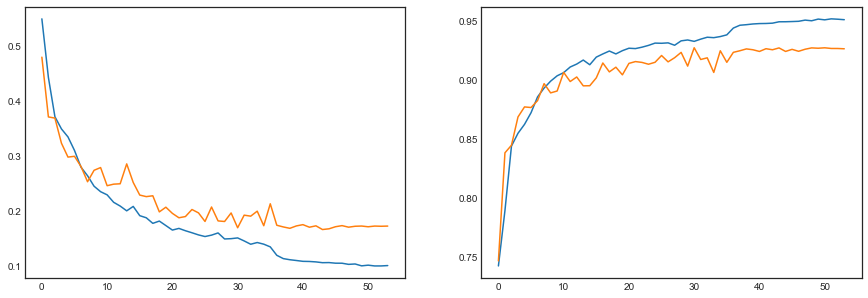

In [23]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [24]:
model = load_model("./keras.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [25]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

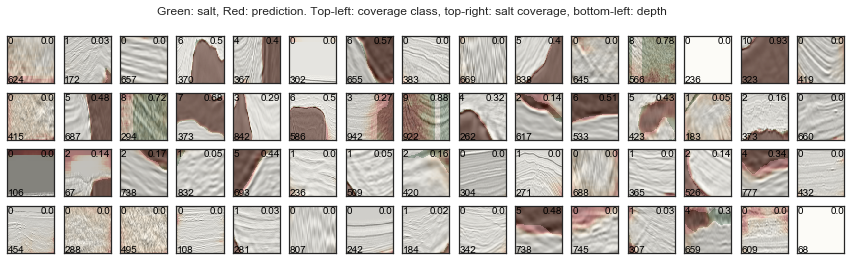

In [26]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [27]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [28]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [29]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

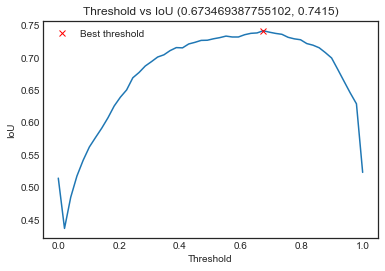

In [30]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

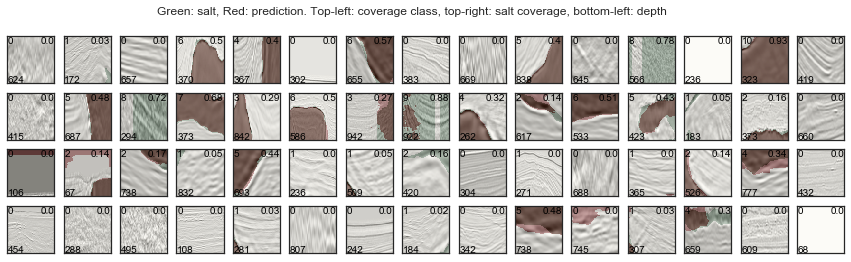

In [31]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Submission
Load, predict and submit the test image predictions.

In [32]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [33]:
x_test = np.array([upsample(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [34]:
preds_test = model.predict(x_test)

In [35]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [36]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')